<a href="https://colab.research.google.com/github/thijsgelton/P10-G7_GANs/blob/main/P11_G7_wave_function_collapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
SOW-MKI95 Computer Graphics & Computer Vision
Wave function collapse
```

```
Group number: ...
Student 1 name/number: ...
Student 2 name/number: ...
...
```

# In this practical, you are provided with the wave function collapse tutorial and the implementation of the tiled model by [https://terbium.io/](https://terbium.io/).

# Your tasks are to:

# - Carefully read the tutorial and run the implementation.
# - Make another tileset yourself or download one from the internet with at least three constraints. Adapt the implementation to work with this tileset.
# - Adapt the implementation to work with backtracking and overlapping model.

You can refer to the following for additional information:

https://github.com/mxgmn/WaveFunctionCollapse  
https://adamsmith.as/papers/wfc_is_constraint_solving_in_the_wild.pdf

The tutorial and the implementation in this notebook are also available online [here](https://terbium.io/2018/11/wave-function-collapse/#generating-from-images). All credit to https://terbium.io/.

# **TUTORIAL / IMPLEMENTATION**

If you're into game design (or maybe someting more exotic, like computer-generated art), you may have needed to generate large random patterns. Maybe because you want infinite levels, or because you're just making randomly-generated levels for your cool roguelike, or you're ~~lazy~~ pressed for time and would like some computer help to generate textures.

A typical technique is to create these using [Perlin noise](https://en.wikipedia.org/wiki/Perlin_noise). Minecraft, for instance, uses a variant of it to generate its sprawling worlds. But Perlin noise is only appropriate if you don't have very strong constraints between the elements of your generated structure. For instance, if you're generating 2D platformer levels, you'll want ladders to always start and finish at platforms. You could post-process your random levels to do that, but it may become very tricky if your constraints are hard to tack onto a generated thing! 

[Wave Function Collapse](https://github.com/mxgmn/WaveFunctionCollapse), or WFC, tries to solve this by integrating any constraints at generation time. If you've never seen examples before, I encourage you to read [the WFC readme](https://github.com/mxgmn/WaveFunctionCollapse/blob/master/README.md), which has some great examples of what WFC can do. Another example of WFC I really like is the appropriately-named [Wave Function Collapse](https://marian42.itch.io/wfc), a 3D WFC-based random city generator.

Here's a simple example of a structure generated by WFC, with a single tile and the constraint that pipes must connect to pipes:

<table style="margin-left: auto; margin-right: auto;"><tr>
    <td style="vertical-align: middle; border: 0px;"><img src="https://terbium.io/2018/11/wave-function-collapse/img/t.png" width="50px;"></td>
    <td style="vertical-align: middle; border: 0px;">→</td>
    <td style="vertical-align: middle; border: 0px;"><img src="https://terbium.io/2018/11/wave-function-collapse/img/t_out.png"></td>
</tr></table>

The WFC process is iterative: we decide what to place in each location in turn, based on what's around it.

<p style="text-align: center;"><img src="https://terbium.io/2018/11/wave-function-collapse/img/t_build.gif"></p>

In an an effort to be easy to understand, this implementation is pretty bare-bones, but I'll discuss some possible variants and optimizations as we go, and note where I'm diverging from the standard. In particular, while the original WFC algorithm extracts data from sample images, this version works by giving it a predefined set of tiles.

This tutorial requires some amount of Numpy knowledge if you want to follow the code closely.

## Preliminary work

If you're interested in how WFC works, but not trying to follow along, feel free to skip to the next section. This part is included for completeness so that the notebook runs out of the box. If you _are_ following along, you'll find the software versions I used at the bottom of the page.

Let's get started with some imports:

In [1]:
import random
import io
import base64
from collections import namedtuple
import numpy as np
from PIL import Image
from IPython import display

The following three functions help us display partial and final states of the generated pattern. Exactly what they're doing will be explained soon; it's really just standard PIL and numpy manipulations.

In [2]:
def blend_many(ims):
    """
    Blends a sequence of images.
    """
    current, *ims = ims
    for i, im in enumerate(ims):
        current = Image.blend(current, im, 1/(i+2))
    return current

In [3]:
def blend_tiles(choices, tiles):
    """
    Given a list of states (True if ruled out, False if not) for each tile,
    and a list of tiles, return a blend of all the tiles that haven't been
    ruled out.
    """
    to_blend = [tiles[i].bitmap for i in range(len(choices)) if choices[i]]
    return blend_many(to_blend)

In [59]:
def show_state(potential, tiles):
    """
    Given a list of states for each tile for each position of the image, return
    an image representing the state of the global image.
    """
    rows = []
    for row in potential:
        print(row)
        rows.append([np.asarray(blend_tiles(t, tiles)) for t in row])

    rows = np.array(rows)
    n_rows, n_cols, tile_height, tile_width, _ = rows.shape
    images = np.swapaxes(rows, 1, 2)
    return Image.fromarray(images.reshape(n_rows*tile_height, n_cols*tile_width, 4))

I think Numpy's default [`nonzero`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.nonzero.html) method [doesn't make a ton of sense](https://stackoverflow.com/questions/7924033/understanding-numpys-nonzero-function). Or maybe I just don't understand how to use it. In any case, here's a version I like better:

In [5]:
def find_true(array):
    """
    Like np.nonzero, except it makes sense.
    """
    transform = int if len(np.asarray(array).shape) == 1 else tuple
    return list(map(transform, np.transpose(np.nonzero(array))))

I've called it `find_true` because we're only going to use it to find the indices of cells that are `True` in boolean arrays.

## Tiles and potential

The first thing we need is tiles to assemble our image from. For this tutorial, I have created five 10x10 pixel images: a straight line, a bend, a cross, a T-joint, and an empty background. You can also use your own! Otherwise, let's load the bitmaps (they're all very small so I'm just loading them as base64-encoded strings):

In [6]:
straight_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAMklEQVQYlWNQVrT9r6xo+988UfN/0yqN/4evOP0/fMXpf9Mqjf/miZr/YfIMowrpqxAAjKLGXfWE8ZAAAAAASUVORK5CYII=')))
bend_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAANklEQVQYlWNQVrT9TwxmIFmheaImXoyisGmVBk6MofDwFSesmHKFRFvdtEoDv2fQFWINHnwKAQHMxl1/fce/AAAAAElFTkSuQmCC')))
blank_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAFElEQVQYlWNQVrT9TwxmGFVIX4UAoDOWARI9hF0AAAAASUVORK5CYII=')))
cross_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAU0lEQVQYlWNQVrT9r6xo+988UfN/0yqN/4evOP0/fMXpf9Mqjf/miZr/YfIMRCs0T9T8D8PYFMIwQ9Mqjf/IGFkhMmaASRDCxCsk2mqiPUP1cAQAKI/idfPNuccAAAAASUVORK5CYII=')))
t_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAWUlEQVQYlWNQVrT9r6xo+988UfN/0yqN/4evOP0/fMXpf9Mqjf/miZr/YfIMRCs0T9T8D8PYFMIwQ9Mqjf/IGFkhMmaASRDCxCtEtwIXRvEMPgwPHkKYaIUAow/UaQFDAc4AAAAASUVORK5CYII=')))

For reference, this is what the images look like:

<table><tbody><tr>
    <td style="border: 0px;"><img src="https://terbium.io/2018/11/wave-function-collapse/img/straight.png" width="50px;"></td>
    <td style="border: 0px;"><img src="https://terbium.io/2018/11/wave-function-collapse/img/bend.png" width="50px;"></td>
    <td style="border: 0px;"><img src="https://terbium.io/2018/11/wave-function-collapse/img/blank.png" width="50px;"></td>
    <td style="border: 0px;"><img src="https://terbium.io/2018/11/wave-function-collapse/img/cross.png" width="50px;"></td>
    <td style="border: 0px;"><img src="https://terbium.io/2018/11/wave-function-collapse/img/t.png" width="50px;"></td>
</tr></tbody></table>

Next, let's define a representation for these tiles. In addition to storing the bitmap itself, we need a way to tell our algorithm which tiles can go next to which others. Otherwise, generating a random pattern would be trivial: just randomly select a tile for each location in the output image, and you're done. It looks like this:

<img src="https://terbium.io/2018/11/wave-function-collapse/img/no-constraints.png" width="200px;">

…not too convincing, right?

Since our only contraint is pipe / no pipe, we'll just keep track of which sides of the tile have pipes, going counterclockwise from the right. For instance, this tile:

<img src="https://terbium.io/2018/11/wave-function-collapse/img/bend.png" width="40px;">

gives us `[True, False, False, True]`. Just start on the right (pipe), then up (no pipe), left (no pipe), and down (pipe). Apart from that, we'll give each tile a name (just for easy identification), and a weight, from which we'll derive a probability of occuring in the output image.

As a side note, you can replace this `True`/`False` choice with any enum to describe more complicated constraints. This code should be able to handle that with no changes.

In [7]:
Tile = namedtuple('Tile', ('name', 'bitmap', 'sides', 'weight'))

We'll turn the 5 tiles we have into 12 by generating all the rotations manually. The reference WFC implementation generates rotations automatically; it's not very hard to do, but this tutorial is long enough as it is.

In [8]:
tiles = [
    Tile('straight_ud', straight_image,
         [False, True, False, True], 1/2),
    Tile('straight_lr', straight_image.transpose(Image.ROTATE_90),
         [True, False, True, False], 1/2),
    Tile('bend_br', bend_image,
         [True, False, False, True], 1/4),
    Tile('bend_tr', bend_image.transpose(Image.ROTATE_90),
         [True, True, False, False], 1/4),
    Tile('bend_tl', bend_image.transpose(Image.ROTATE_180),
         [False, True, True, False], 1/4),
    Tile('bend_bl', bend_image.transpose(Image.ROTATE_270),
         [False, False, True, True], 1/4),
    Tile('t_u', t_image,
         [True, True, True, False], 1/4),
    Tile('t_l', t_image.transpose(Image.ROTATE_90),
         [False, True, True, True], 1/4),
    Tile('t_d', t_image.transpose(Image.ROTATE_180),
         [True, False, True, True], 1/4),
    Tile('t_r', t_image.transpose(Image.ROTATE_270),
         [True, True, False, True], 1/4),
    Tile('blank', blank_image,
         [False, False, False, False], 1),
    Tile('cross', cross_image,
         [True, True, True, True], 1)
]

We also create a dedicated array with tile weights. This will make quickly finding the weight of a given tile easier later.

In [9]:
weights = np.asarray([t.weight for t in tiles])

After all this set up, we're ready to get to WFC itself. For this example, we'll generate an image 30 by 30 elements.

Initially, we create the image as a grid where each element is a superposition of all possible tiles. Thus the state is represented by an array of 30×30×12 (since we have 12 tiles) boolean elements. I'm calling this array `potential`. For instance, the value `potential[12][2][5]` is true if and only if the element at coordinates (12, 5) can still be tile number 5, in our case `'bend_bl'`.

The goal of the WFC algorithm will be to reduce the potential until we've picked one tile for each image element.

We'll visualize the algorithm's progression by representing each element as a blend of all the tiles we haven't ruled out so far at that location. Initially, none of the tiles are ruled out, so the result just looks like a blend of every tile at each location:

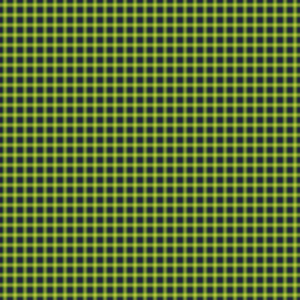

In [10]:
potential = np.full((30, 30, len(tiles)), True)
display.display(show_state(potential, tiles))

## The Wave Function Collapse algorithm

How do we reduce possibilities? Initially, we can just choose a location at random and assign a random tile to that location. This may reduce the possibilities for other locations around that initial one, or, depending on the tileset, even completely determine what tiles we must pick in some places. Once we've propagated these changes, we're ready to pick the next tile.

Here's what it looks like:

 1. If all locations are decided, we are done.
 2. If any location has no choices left, we've failed. I'll talk about how to handle this below.
 3. Otherwise, find the undecided location with the fewest remaining choices.
 4. (_Collapse_ step) Pick a tile at random among those that are still possible for this location. Mark this tile as the only remaining possibility for this location.
 5. (_Propagation_ step) This choice is likely to rule out some possible tiles at neighboring locations, which in turn can rule out possibilities in their neighbors. We need to update our potential to reflect this.
 6. ➰ Loop ➰.
 
The following method implements a single iteration of this algorithm. I've marked the steps above in the code, to make it easier to follow.

<!--Note how it starts by copying the potential. It would be more efficient to reuse the same potential array and do everything in place, but working on fresh data is useful for debugging and in order to implement backtracking.-->

In [11]:
def run_iteration(old_potential):
    potential = old_potential.copy()
    to_collapse = location_with_fewest_choices(potential) #3
    if to_collapse is None:                               #1
        raise StopIteration()
    elif not np.any(potential[to_collapse]):              #2
        raise Exception(f"No choices left at {to_collapse}")
    else:                                                 #4 ↓
        nonzero = find_true(potential[to_collapse])
        tile_probs = weights[nonzero]/sum(weights[nonzero])
        selected_tile = np.random.choice(nonzero, p=tile_probs)
        potential[to_collapse] = False
        potential[to_collapse][selected_tile] = True
        propagate(potential, to_collapse)                 #5
    return potential

Let's now look at the constituent functions. The easiest is `locations_with_fewest_choices`, which does what it says on the tin and returns the _undecided_ element with the fewest choices left, or returns `None` if all elements are decided. (The reference WFC implementation computes a proper entropy based on tile weights instead of counting possibilities. I've found that it doesn't make a huge difference for the tile-based algorithm.)

There isn't much else to note, besides the fact that we break ties at random, for that sweet extra randomness.

In [12]:
def location_with_fewest_choices(potential):
    num_choices = np.sum(potential, axis=2, dtype='float32')
    num_choices[num_choices == 1] = np.inf
    candidate_locations = find_true(num_choices == num_choices.min())
    location = random.choice(candidate_locations)
    if num_choices[location] == np.inf:
        return None
    return location

### Constraint propagation

The only thing left to implement is `propagate`, which will propagate the newly-created constants. We'll need a few helpers to make it easier to digest. First, a `Direction` class that knows how to reverse itself. Note how the enum values match the order in which we defined constraints earlier (so that `tile.sides[Direction.LEFT.value]` returns the constraint on the left side of the tile).

In [13]:
from enum import Enum, auto

class Direction(Enum):
    RIGHT = 0; UP = 1; LEFT = 2; DOWN = 3
    
    def reverse(self):
        return {Direction.RIGHT: Direction.LEFT,
                Direction.LEFT: Direction.RIGHT,
                Direction.UP: Direction.DOWN,
                Direction.DOWN: Direction.UP}[self]

The second helper is a pretty boring function that returns a list of neighbors for a given location; really it's just useful for its edge-case handling. It also returns the direction each neighbor is in.

In [14]:
def neighbors(location, height, width):
    res = []
    x, y = location
    if x != 0:
        res.append((Direction.UP, x-1, y))
    if y != 0:
        res.append((Direction.LEFT, x, y-1))
    if x < height - 1:
        res.append((Direction.DOWN, x+1, y))
    if y < width - 1:
        res.append((Direction.RIGHT, x, y+1))
    return res

We can now get to the meat of the Propagate step. When I first heard of WFC, I didn't know much about constraint propagation, and the first thing I thought of doing was a depth- or breath-first traversal of the image to propagate constraints. This almost works, except for the fact that these traversal methods will only visit a node once, whereas constraints can flow backwards, requiring a node to be updated more than once. So instead of stopping when we hit a node we've already visited, we keep traversing until we detect that we're not making any new changes.

More formally, we:

 1. Mark the cell we just collapsed as needing an update.
 2. For each cell that needs an update _U_ ,
    1. For each of that cell's neighbors _N_,
       1. Remove any tile that is no longer compatible with _U_'s possible tiles.
       2. If we did remove any tiles, we need to propagate any new constraints, so mark _N_ as needing an update on the next iteration.
 3. If any cells still need to be updated, go back to step 2. Otherwise, we're done.
 
<span style="font-size: 70%;">Exercise for people nostalgic of CS classes: prove this algorithm terminates 🙃</span>

In [15]:
def propagate(potential, start_location):
    height, width = potential.shape[:2]
    needs_update = np.full((height, width), False)
    needs_update[start_location] = True
    while np.any(needs_update):
        needs_update_next = np.full((height, width), False)
        locations = find_true(needs_update)
        for location in locations:
            possible_tiles = [tiles[n] for n in find_true(potential[location])]
            for neighbor in neighbors(location, height, width):
                neighbor_direction, neighbor_x, neighbor_y = neighbor
                neighbor_location = (neighbor_x, neighbor_y)
                was_updated = add_constraint(potential, neighbor_location,
                                             neighbor_direction, possible_tiles)
                needs_update_next[location] |= was_updated
        needs_update = needs_update_next

You may have noticed that I have once again been mischievous and have hidden away some details under the as-yet-undefined function `add_constraint`. `add_constraint` builds a set of the sides (pipe or no pipe, i.e. `True` or `False`) that are still possible at the source location, and rules out any tiles that were still possible at the target location.

It's possible for WFC to fail: after we make a choice of tile for some location, we may realize during propagation that this choice ends up ruling out all possibilities at some other location. We detect this type of contradiction in this method too.

In [16]:
def add_constraint(potential, location, incoming_direction, possible_tiles):
    neighbor_constraint = {t.sides[incoming_direction.value] for t in possible_tiles}
    outgoing_direction = incoming_direction.reverse()
    changed = False
    for i_p, p in enumerate(potential[location]):
        if not p:
            continue
        if tiles[i_p].sides[outgoing_direction.value] not in neighbor_constraint:
            potential[location][i_p] = False
            changed = True
    if not np.any(potential[location]):
        raise Exception(f"No patterns left at {location}")
    return changed

## Putting it in a loop

Now that we have all the bits, we can just call our `run_iteration` function in a loop and get some cool-looking results!

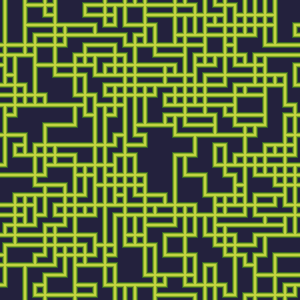

In [17]:
p = potential
images = [show_state(p, tiles)]
while True:
    try:
        p = run_iteration(p)
        images.append(show_state(p, tiles))  # Move me for speed
    except StopIteration as e:
        break
    except Exception as e:
        print(e)
        break
        
out = io.BytesIO()
images[0].save(out, format='gif', save_all=True, append_images=images[1:],
               duration=50, loop=0)
images[-1]

(If you're running this notebook as we're going, you may notice that the cell above takes a while [typically about a minute] to run. Could WFC be slow 😮? Well, this implementation isn't blazing fast, but it can do this 30×30 grid in way less than a second. What takes most of the time is actually my poorly-written `show_state` method. If you move the call to `show_state` to outside the loop, you'll lose the cool GIF but it'll run faster.)

Since we save the state after each iteration, we can display a nice GIF of WFC doing its thing:

In [20]:
import base64
from IPython import display
display.HTML('<img src="data:image/gif;base64,{0}">'
             .format(base64.b64encode(out.getvalue()).decode('utf8')))

<video width="300" height="300" autoplay loop>
  <source src="img/generation.webm" type="video/webm" />
  <source src="img/generation.mp4" type="video/mp4" />
</video>

## Going further

Many different optimizations and variants of WFC exist. I'll talk about two important aspects that are present in many real-life WFC implementations. See the references for more info.

### Backtracking

WFC almost always succeeds with the tileset I gave here. If you mess with the tileset a little, however, you'll realize that it's not always the case. Keeping only the four "T" tiles, for instance, results in a much lower success rate, as WFC runs into contradictions and quits. (You should still be able to get something out if you run WFC ~10 times).

One option to deal with that is to just keep retrying, which can trivially be implemented on top of this solution. A more sophisticated option is to implement _backtracking_: when we hit a contradiction, we go back to a previous state and try again. This allows us to keep some of the already computed output image, while hopefully throwing out enough bad choices to get rid of the contradictory situation.

### Generating from images

An interesting aspect of the original WFC which I haven't talked about at all is the ability to automatically extract tiles from images. This is how many of the examples on WFC's impressive readme page are implemented. The key idea is to extract all 3x3 pixel blobs (or any other size, but it has to be kept relatively small) from the original image, determine their weights and which can be placed next to which, and then run this tiled algorithm.

## References

You can [download the notebook](wave-function-collapse.ipynb). Software versions used:

```
Python 3.7.1
jupyter==1.0.0
numpy==1.15.4
Pillow==5.3.0
```

* [WFC GitHub Page](https://github.com/mxgmn/WaveFunctionCollapse)
* [Wave Function Collapse](https://marian42.itch.io/wfc), a 3D WFC-based city generator that inspired this post
* [Karth, Isaac, and Adam M. Smith. "WaveFunctionCollapse is constraint solving in the wild." _Proceedings of the 12th International Conference on the Foundations of Digital Games_. ACM, 2017.](https://adamsmith.as/papers/wfc_is_constraint_solving_in_the_wild.pdf)

Please leave any comments or feedback below!

## Make another tileset yourself or download one from the internet with at least three constraints. Adapt the implementation to work with this tileset.

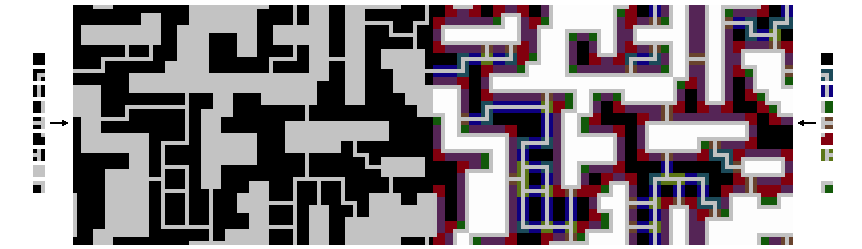

In [82]:
bend_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAMAAAADCAIAAADZSiLoAAAACXBIWXMAAAsSAAALEgHS3X78AAAAGElEQVQImWM4fPgwAwMDAwMDEwMMMMLFAFKUBJbC97U1AAAAAElFTkSuQmCC')))
corner_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAMAAAADCAIAAADZSiLoAAAACXBIWXMAAAsSAAALEgHS3X78AAAAFUlEQVQImWNgYGBgYGA4fPgwAxYAADJkAko2MFGoAAAAAElFTkSuQmCC')))
corridor_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAMAAAADCAIAAADZSiLoAAAACXBIWXMAAAsSAAALEgHS3X78AAAAF0lEQVQImWNgYGA4fPgwAwMDEwMMIFgAOXsCTgSo91gAAAAASUVORK5CYII=')))
door_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAMAAAADCAIAAADZSiLoAAAACXBIWXMAAAsSAAALEgHS3X78AAAAE0lEQVQImWM8fPgwAxxAOExwPgBikwSW9Gy5dAAAAABJRU5ErkJggg==')))
empty_grey_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAMAAAADCAIAAADZSiLoAAAACXBIWXMAAAsSAAALEgHS3X78AAAAF0lEQVQImWM8fPgwAwMDAwMDEwMMIFgAQHQCT/raEP4AAAAASUVORK5CYII=')))
empty_black_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAMAAAADCAIAAADZSiLoAAAACXBIWXMAAAsSAAALEgHS3X78AAAAF0lEQVQImWM8fPgwAwMDAwMDEwMMIFgAQHQCT/raEP4AAAAASUVORK5CYII=')))
t_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAMAAAADCAIAAADZSiLoAAAACXBIWXMAAAsSAAALEgHS3X78AAAAFElEQVQImWNggAHGw4cPwzkMEA4ANMEElIiVwmcAAAAASUVORK5CYII=')))

In [83]:
class RoomsEnum(Enum):
    """
    Using B(lack) and G(rey) to annotate which sides are compatible. Starting on the left of a side.
    """
    GGG = 0
    BBB = 1
    BBG = 2
    GBB = 3
    BGB = 4
    GBG = 5

In [84]:
corridor_up = [RoomsEnum.BBB, RoomsEnum.BGB, RoomsEnum.BBB, RoomsEnum.BGB]
bend_br = [RoomsEnum.BGB, RoomsEnum.BBB, RoomsEnum.BBB, RoomsEnum.BGB]
corner_br = [RoomsEnum.BBG, RoomsEnum.GBB, RoomsEnum.BBB, RoomsEnum.BBB]
door_br = [RoomsEnum.GGG, RoomsEnum.GBB, RoomsEnum.BGB, RoomsEnum.BBG]
t_u = [RoomsEnum.BBB, RoomsEnum.BGB, RoomsEnum.BGB, RoomsEnum.BGB]

tiles = [
    Tile('corridor_up', corridor_image,
         corridor_up, 1/2),
    Tile('corridor_lr', corridor_image.transpose(Image.ROTATE_90),
         np.roll(corridor_up, 1), 1/2),
    Tile('bend_br', bend_image,
         bend_br, 1/4),
    Tile('bend_tr', bend_image.transpose(Image.ROTATE_90),
         np.roll(bend_br, 1), 1/4),
    Tile('bend_tl', bend_image.transpose(Image.ROTATE_180),
         np.roll(bend_br, 2), 1/4),
    Tile('bend_bl', bend_image.transpose(Image.ROTATE_270),
         np.roll(bend_br, 3), 1/4),
    Tile('corner_br', corner_image,
         corner_br, 1/4),
    Tile('corner_tr', corner_image.transpose(Image.ROTATE_90),
         np.roll(corner_br, 1), 1/4),
    Tile('corner_tl', corner_image.transpose(Image.ROTATE_180),
         np.roll(corner_br, 2), 1/4),
    Tile('corner_bl', corner_image.transpose(Image.ROTATE_270),
         np.roll(corner_br, 3), 1/4),
    Tile('door_br', door_image,
         door_br, 1/4),
    Tile('door_tr', door_image.transpose(Image.ROTATE_90),
         np.roll(door_br, 1), 1/4),
    Tile('door_tl', door_image.transpose(Image.ROTATE_180),
         np.roll(door_br, 2), 1/4),
    Tile('door_bl', door_image.transpose(Image.ROTATE_270),
         np.roll(door_br, 3), 1/4),
    Tile('t_u', t_image,
         t_u, 1/4),
    Tile('t_l', t_image.transpose(Image.ROTATE_90),
         np.roll(t_u, 1), 1/4),
    Tile('t_d', t_image.transpose(Image.ROTATE_180),
         np.roll(t_u, 2), 1/4),
    Tile('t_r', t_image.transpose(Image.ROTATE_270),
         np.roll(t_u, 3), 1/4),
    Tile('empty_grey', empty_grey_image,
         4 * [RoomsEnum.GGG], 1),
    Tile('empty_black', empty_grey_image,
         4 * [RoomsEnum.BBB], 1)
]

In [85]:
weights = np.asarray([t.weight for t in tiles])

In [86]:
def blend_many(ims):
    """
    Blends a sequence of images.
    """
    current, *ims = ims
    for i, im in enumerate(ims):
        current = Image.blend(current, im, 1/(i+2))
    return current

In [87]:
def blend_tiles(choices, tiles):
    """
    Given a list of states (True if ruled out, False if not) for each tile,
    and a list of tiles, return a blend of all the tiles that haven't been
    ruled out.
    """
    to_blend = []
    for i in range(len(choices)):
        if choices[i]:
            to_blend.append(tiles[i].bitmap)
    return blend_many(to_blend)

In [88]:
def show_state(potential, tiles):
    """
    Given a list of states for each tile for each position of the image, return
    an image representing the state of the global image.
    """
    rows = []
    for row in potential:
        rows.append([np.asarray(blend_tiles(t, tiles)) for t in row])

    rows = np.array(rows)
    n_rows, n_cols, tile_height, tile_width, _ = rows.shape
    images = np.swapaxes(rows, 1, 2)
    return Image.fromarray(images.reshape(n_rows*tile_height, n_cols*tile_width, 4))

In [89]:
potential = np.full((30, 30, len(tiles)), True)
print(potential.shape)
display.display(show_state(potential, tiles))

(30, 30, 20)


ValueError: ignored

In [31]:
p = potential
images = [show_state(p, tiles)]
while True:
    try:
        p = run_iteration(p)
        images.append(show_state(p, tiles))  # Move me for speed
    except StopIteration as e:
        break
    except Exception as e:
        print(e)
        break
        
out = io.BytesIO()
images[0].save(out, format='gif', save_all=True, append_images=images[1:],
               duration=50, loop=0)
images[-1]

ValueError: ignored